In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import json

from pyinstrument import Profiler
%load_ext pyinstrument

from sklearn import set_config
set_config(assume_finite=True) 

import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import datetime as dt

# Procedure for generating VoC curves

1. Generate 120000 RFFs using `make_RFF`
2. For $t \in \{12, \dots, len(S)\}$:
   1. Standardize the RFFs by their standard deviation in the training sample i.e. sample $\{S_{t-T}, \dots S_{t-1}\}$ of the last $T$ observations, for $T \in \{12, 60, 120\}$. Also, standardize $S_{t}$ by the same standard deviation. Output `NaN` if $t < T$.
   2. Estimate the model by ridge regression with $P\in \{2,\dots, 12000\}$ and ridge shrinkage parameter $log_{10}(z) \in \{−3,\dots, 3\}$. In our case we are taking 9 values for $P$ and 7 values for $z$, so we have 63 models to estimate for each $t$.
3. From the sequence of out-of-sample predictions and strategy returns in step 2. calculate:
   1. average $||\hat{\beta}||^2$ across training samples,
   2. out-of-sample $R^2$ 
   3. out-of-sample average return of the timing strategy
   4. volatility of the timing strategy
   5. Sharpe ratio of the timing strategy


In the following subsections of the notebook we inspect each of the steps, check the results of each step and profile the code in each step to identify bottlenecks.

## 1. Generate RFFs

In [45]:
data = pd.read_csv("../data/processed/processed_data.csv", index_col=0, parse_dates=True)
P=12000 # number of pairs
gamma=2

def make_RFF(data, P, gamma=2, seed=59148):
    np.random.seed(seed)
    omegas = np.random.normal(0, 1, (15, int(P/2)))
    G=data.iloc[:,:-1] # remove last column which is the target variable
    A = gamma * G @ omegas
    A_sin = np.sin(A).rename(columns=lambda x: int(x*2)) 
    A_cos = np.cos(A).rename(columns=lambda x: int(x*2+1)) 
    A_combined = pd.concat([A_sin, A_cos], axis=1)
    S = A_combined.reindex(np.arange(P), axis=1, copy=True)  # reorder columns by index
    return S

In [46]:
S = make_RFF(data=data, P=P, gamma=gamma, seed=59148)
R = data.iloc[:,-1] # target variable, it is already shifted

In [47]:
S # ok

,0,1,2,3,4,5,6,7,8,9,...,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999
date,,,,,,,,,,,,,,,,,,,,,
1929-12-31,0.088591,-0.996068,0.516401,-0.856347,0.657782,0.753208,-0.271437,-0.962456,-0.110582,0.993867,...,0.735934,-0.677053,0.848989,0.528410,-0.979918,-0.199402,-0.956407,0.292038,0.497545,0.867438
1930-01-31,-0.359463,-0.933159,-0.498059,0.867143,0.552842,0.833286,0.902721,0.430226,-0.924971,-0.380037,...,0.522750,-0.852486,0.907462,0.420134,0.320770,0.947157,-0.303524,0.952824,-0.043497,0.999054
1930-02-28,0.763230,0.646126,-0.066606,-0.997779,0.716922,-0.697153,-0.336840,-0.941562,0.456696,0.889623,...,-0.015783,0.999875,0.788395,-0.615170,-0.533040,0.846090,-0.698122,0.715979,-0.712592,-0.701579
1930-03-31,0.908116,0.418719,-0.556422,-0.830900,-0.634389,0.773014,0.994887,-0.100991,-0.998280,0.058624,...,0.283701,-0.958913,-0.841526,-0.540216,0.562735,0.826637,-0.934425,0.356160,0.559879,-0.828575
1930-04-30,0.469082,-0.883154,-0.443621,0.896214,0.040475,0.999181,-0.488568,-0.872526,-0.858504,0.512807,...,0.758765,-0.651365,-0.991461,-0.130404,-0.924347,-0.381554,0.488892,0.872344,-0.842947,0.537996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,-0.764101,-0.645097,-0.961110,0.276165,-0.957024,0.290010,-0.949193,0.314695,-0.558378,0.829587,...,-0.971923,-0.235299,-0.237264,-0.971445,0.966354,-0.257215,-0.291967,0.956428,0.402599,-0.915376
2022-08-31,-0.167151,-0.985931,0.490197,-0.871612,0.900854,-0.434122,0.410165,-0.912011,-0.635345,0.772229,...,-0.313310,-0.949651,0.586885,-0.809670,-0.264131,-0.964487,0.191276,-0.981536,-0.610628,-0.791917
2022-09-30,-0.938495,0.345292,0.270907,-0.962605,0.933237,0.359260,-0.640688,-0.767802,0.051438,0.998676,...,-0.678265,-0.734817,-0.389222,-0.921144,0.747110,-0.664701,0.577451,0.816425,-0.983935,-0.178528


In [48]:
R

date
1929-12-31    0.694734
1930-01-31    0.274144
1930-02-28    0.797222
1930-03-31   -0.185709
1930-04-30   -0.160907
                ...   
2022-07-31   -0.740901
2022-08-31   -1.516081
2022-09-30    1.250263
2022-10-31    0.800499
2022-11-30   -0.950642
Name: R, Length: 1116, dtype: float64

### 1.1 Profiling

In [49]:
%%pyinstrument
S = make_RFF(data=data, P=P, gamma=gamma)
# 0.45s cashed, 3.9-4.7s uncached 
# apply takes 70% time

_     ._   __/__   _ _  _  _ _/_   Recorded: 00:48:08  Samples:  30
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.696     CPU time: 1.371
/   _/                      v4.6.2

Program: /home/miroslav/miniforge3/envs/voc/lib/python3.12/site-packages/ipykernel_launcher.py --f=/home/miroslav/.local/share/jupyter/runtime/kernel-v2-2018470dTDUU1Ktkm3c.json

0.695 <module>  ../../../../../../../tmp/ipykernel_2019003/2698441166.py:1
|- 0.688 make_RFF  ../../../../../../../tmp/ipykernel_2019003/1102542553.py:5
|  |- 0.340 DataFrame.__array_ufunc__  pandas/core/generic.py:2167
|  |     [4 frames hidden]  pandas
|  |        0.340 NumpyBlock.apply  pandas/core/internals/blocks.py:387
|  |- 0.119 concat  pandas/core/reshape/concat.py:157
|  |     [8 frames hidden]  pandas, <built-in>
|  |- 0.105 DataFrame.reindex  pandas/core/frame.py:5359
|  |     [9 frames hidden]  pandas
|  |- 0.065 DataFrame.rename  pandas/core/frame.py:5636
|  |     [8 frames hidden]  pandas, <built-in>
|  `- 0.053 DataFrame.__matmul__  pandas/core/frame.py:1783
|        [2 frames hidden]  pandas
`- 0.007 [self]  ../../../../../../../tmp/ipykernel_2019003/2698441166.py

Let's try to improve the performance can be done by switching from pandas dataframe to numpy arrays.

In [50]:
G=data.iloc[:,:-1].values # remove last column which is the target variable
G

array([[ 9.13788829,  0.        ,  0.99611347, ...,  4.64768779,
         4.44483069, -2.06545938],
       [ 8.74478495, -0.90263792,  0.14155092, ...,  4.37144973,
         3.99673464,  0.46338983],
       [ 8.26222406, -0.91273557,  0.17250821, ...,  4.35133748,
         3.98236255,  1.0025477 ],
       ...,
       [ 1.62070993, -0.06722329,  0.82206722, ...,  0.93036597,
        -0.43938156, -0.74327159],
       [ 1.70985273,  0.40814285,  1.0840119 , ...,  0.81626823,
        -0.59336538, -1.68547048],
       [ 1.72533774,  0.7700837 ,  1.05745214, ...,  0.77223004,
        -0.66160578,  1.47783364]])

In [51]:
def make_RFF_np(data, P, gamma=2, seed=59148):
    np.random.seed(seed)

    def generate_omegas():
        return np.random.normal(0, 1, (15, int(P/2)))
    omegas = generate_omegas()

    def make_A(data, gamma, omegas):
        return gamma * data @ omegas
    A = make_A(data, gamma, omegas)
    
    def make_S(A):
        S_sin = np.sin(A) 
        S_cos = np.cos(A)
        return S_sin, S_cos
    S_sin, S_cos = make_S(A)
    # combine sin and cos parts into one matrix S by making sin take even columns and cos take odd columns
    
    def combine_sin_cos(S_sin, S_cos):
        S = np.full((S_sin.shape[0], S_sin.shape[1] + S_cos.shape[1]), fill_value=np.nan, dtype=S_sin.dtype)
        S[:, 0::2] = S_sin
        S[:, 1::2] = S_cos
        return S

    return combine_sin_cos(S_sin, S_cos)

In [52]:
%%pyinstrument
S = make_RFF_np(data=G, P=P, gamma=gamma)

# 0.4-0.5s cashed, 3.5s uncached
# main bottleneck is applying sin and cos to A (70% of time)

_     ._   __/__   _ _  _  _ _/_   Recorded: 00:48:09  Samples:  6
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.533     CPU time: 1.546
/   _/                      v4.6.2

Program: /home/miroslav/miniforge3/envs/voc/lib/python3.12/site-packages/ipykernel_launcher.py --f=/home/miroslav/.local/share/jupyter/runtime/kernel-v2-2018470dTDUU1Ktkm3c.json

0.533 <module>  ../../../../../../../tmp/ipykernel_2019003/1926690765.py:1
|- 0.525 make_RFF_np  ../../../../../../../tmp/ipykernel_2019003/383780573.py:1
|  |- 0.329 make_S  ../../../../../../../tmp/ipykernel_2019003/383780573.py:12
|  |- 0.110 combine_sin_cos  ../../../../../../../tmp/ipykernel_2019003/383780573.py:19
|  |  |- 0.057 full  numpy/core/numeric.py:274
|  |  `- 0.053 [self]  ../../../../../../../tmp/ipykernel_2019003/383780573.py
|  `- 0.082 make_A  ../../../../../../../tmp/ipykernel_2019003/383780573.py:8
`- 0.008 [self]  ../../../../../../../tmp/ipykernel_2019003/1926690765.py

No significant improvement is made. No need for further inspections, since `make_RFF` will be called 1000 times in the main loop ().

It should be noted that the speed is heavily dependent on caching of the data, which is done in the step when the data is loaded from the csv. For non-cached data, the speed is significantly slower (~ 10 times), comes to around 4 seconds per run. So, in the worst case scenario, the total time for this step would be 1000 * 4 = 4000 seconds ~ 1 hour.

The final function to be used:

In [53]:
def make_rff(G, P, gamma=2, seed=59148, output_type='numpy'):
    np.random.seed(seed)
    omegas = np.random.normal(0, 1, (15, int(P/2)))
    A = gamma * G @ omegas
    S_sin = np.sin(A) 
    S_cos = np.cos(A)
    S = np.full((S_sin.shape[0], S_sin.shape[1] + S_cos.shape[1]), fill_value=np.nan, dtype=S_sin.dtype)
    S[:, 0::2] = S_sin
    S[:, 1::2] = S_cos

    if output_type == 'pandas':
        S = pd.DataFrame(data=S, index=G.index, columns=np.arange(P))
    elif output_type == 'numpy':
        return S
    else:
        raise ValueError('output_type must be "pandas" or "numpy"')

In [54]:
data = pd.read_csv("../data/processed/processed_data.csv", index_col=0, parse_dates=True)
P=12000 # number of pairs
gamma=2

# inputs
G = data.iloc[:,:-1].values # remove last column which is the target variable
R = data.iloc[:,-1].values # target variable, it is already shifted
S = make_rff(G, P, gamma=gamma, output_type='numpy')

## 2. Model fitting

[VoC] (regularized) least-squares estimators of the form

$$ \hat{\beta}(z) = \left( zI + T^{-1} \sum_t S_t S_t' \right)^{-1} \frac{1}{T} \sum_t S_t R_{t+1}$$

The ridge regression in The Elements of Statistical Learning (Hastie et al., 2009) is equivalent to the above equation with $z T = \lambda $ and given as 

$$ \hat{\beta}(\lambda) = \left( \lambda I + X^T X \right)^{-1}X^Ty$$

In scikit-learn parameter $\lambda$ is labeled with $\alpha$.

In [55]:
def single_run(run_inputs, run_params, delta_t=1):
    """
    Run the backtest for a single run.
    S: matrix of features
    R: vector of target variable, shifted once 
    T_list: list of training window lengths
    model_list: list of models to train (ridge regressions with different lambdas)
    P_list: list of number of features to use for each model
    delta_t: time step for retraining the model

    Returns:
    """

    S, R = run_inputs
    T_list, P_list, model_dict = run_params

    # initialize arrays for storing results
    num_of_models = len(model_dict[T_list[0]])

    min_T = min(T_list) # usually =12

    # dimensions: (ts, Ts, Ps, lambdas)
    output_shape = (len(S)-min_T, len(T_list), len(P_list), num_of_models)
    beta_norm_sq = np.full(shape=output_shape, 
                    fill_value=np.nan, 
                    dtype=np.float64)
    return_forecasts = np.full(shape=output_shape, 
                               fill_value=np.nan, 
                               dtype=np.float64)
    strategy_returns = np.full(shape=output_shape, 
                               fill_value=np.nan, 
                               dtype=np.float64)

    # initialize arrays for storing intermediate variables
    # training_std = np.full((len(T_arr), S.shape[1]), fill_value=np.nan, dtype=np.float64)

    def my_std(x):
        return np.sqrt(np.sum(np.square(x - x.mean(axis=0)))/len(x))

    def standardize(t):
        training_sets = []

        for T in T_list:

            # this take a lot of time to compute
            # train_std = trainX.std(axis=0) 
            # train_std = np.sqrt(np.sum((trainX - train_mean)**2, axis=0)/T) # this is equivalent to trainX.std(axis=0)
            if t-T < 1:
                training_sets.append((np.nan, np.nan))
            else:
                training_std = my_std(S[t-T:t])
                trainX = S[t-T:t] / training_std
                forecastX = S[t] / training_std
                training_sets.append((trainX, forecastX))

        return training_sets

    grid = [(P_index, model_index) 
            for P_index in range(len(P_list)) 
            for model_index in range(num_of_models)]
    

    for t in range(min_T, len(S), delta_t):
        # print progress
        if t%100==0:
            print(f"progress: {t/(len(S)-min_T):2.1%}")

        # one standardization for all models, all complexities
        training_sets = standardize(t)

        for P_index, model_index in grid:
            for T_index in range(len(T_list)):
                T = T_list[T_index]

                if t-T < 1:
                    continue
                else: 
                    P = P_list[P_index]
                    # get model of appropriate shrinkage lambda=T*z, z is tracked by model_index
                    model = model_dict[T][model_index]
                    
                    trainX, forecastX = training_sets[T_index]
                    trainY = R[t-T:t]
                    # take first P features for training
                    model.fit(trainX[:,:P], trainY) 
                    forecastY = model.predict(forecastX[:P].reshape(1,-1))

                    # store results 
                    beta_norm_sq[t-min_T, T_index, P_index, model_index] = np.sum(np.square(model.coef_))
                    return_forecasts[t-min_T, T_index, P_index, model_index] = forecastY[0]
                    strategy_returns[t-min_T, T_index, P_index, model_index] = forecastY[0] * R[t]

    return beta_norm_sq, return_forecasts, strategy_returns

In [56]:
# test run
T_list = [60, 120]
z_list = [0.01, 100]
model_dict = {T: [Ridge(alpha=T*z, solver="auto", fit_intercept = False) for z in z_list] for T in T_list}
P_list = [32768, 12000]
delta_t=1

run_inputs = (S, R)
run_params = (T_list, P_list, model_dict)

In [57]:
%%pyinstrument
b, r, sr = single_run(run_inputs, run_params, delta_t)

progress: 9.5%


KeyboardInterrupt: 

_     ._   __/__   _ _  _  _ _/_   Recorded: 00:48:10  Samples:  2376
 /_//_/// /_\ / //_// / //_'/ //     Duration: 8.386     CPU time: 57.499
/   _/                      v4.6.2

Program: /home/miroslav/miniforge3/envs/voc/lib/python3.12/site-packages/ipykernel_launcher.py --f=/home/miroslav/.local/share/jupyter/runtime/kernel-v2-2018470dTDUU1Ktkm3c.json

8.354 <module>  ../../../../../../../tmp/ipykernel_2019003/4008075110.py:1
`- 8.354 single_run  ../../../../../../../tmp/ipykernel_2019003/871893489.py:1
   |- 6.247 wrapper  sklearn/base.py:1457
   |     [16 frames hidden]  sklearn, <built-in>
   |        4.628 safe_sparse_dot  sklearn/utils/extmath.py:164
   |        `- 4.609 [self]  sklearn/utils/extmath.py
   |- 1.196 standardize  ../../../../../../../tmp/ipykernel_2019003/871893489.py:40
   |  |- 0.853 my_std  ../../../../../../../tmp/ipykernel_2019003/871893489.py:37
   |  |  |- 0.576 [self]  ../../../../../../../tmp/ipykernel_2019003/871893489.py
   |  |  `- 0.204 _mean  numpy/core/_methods.py:101
   |  |        [2 frames hidden]  numpy, <built-in>
   |  `- 0.344 [self]  ../../../../../../../tmp/ipykernel_2019003/871893489.py
   `- 0.875 Ridge.predict  sklearn/linear_model/_base.py:272
         [3 frames hidden]  sklearn

### 2.1 Profiling

50s for 8 points in 2x2x2 P-z-T grid, i.e. 6.5s per node.

Goal:
- $P \in [2, 8, 32, 128, 512, 2048, 8192, 32768, 12000]$
- $log10(z) \in [−3,−2,−1, 0, 1, 2, 3] $
- $T \in [12, 60, 120]$

Total runs: 9 * 7 * 3 = 189 nodes \
Total time: 189 * 6.5s = 21 minutes

It should be repeated up to 1000 times for low P (and low T?), and results should be averaged. For big P we can perform smaller number of repetitions.

Bottle necks:
- Ridge fitting wastes time on standardization and checking input data

Solvers and their performance:
solver="auto" - 50-70s depending on caching /
solver="lsqr" - 85s /
solver="sag" - way too slow


In [ ]:
# full parameter set

T_list = [12, 60, 120]
z_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
model_dict = {T: [Ridge(alpha=T*z, fit_intercept = False) for z in z_list] for T in T_list}
P_list = [2**i for i in range(1, 14)]
P_list.append(12000)
delta_t=1

run_inputs = (S, R)
run_params = (T_list, P_list, model_dict)

### Manual fitting

$$ \left( \lambda I + X^T X \right) \hat{\beta}(z) = X^Ty$$

$$ \left( \lambda I + S^T S \right) \hat{\beta}(z) = S^TR$$

The idea is to try to speedup the process of fitting the Ridge regression by manually solving the system of linear equations. This way, we would save time on operations done by the Ridge solver, such as standardization and checking the input data. **No speedup is achieved**, so this part of code is saved in case it is needed in the future.

In [ ]:
from scipy.linalg import lstsq
from numpy.linalg import lstsq as np_lstsq

def single_run_lsqr(S, R, T_list, model_dict, P_list, delta_t=1):
    """
    Run the backtest for a single run.
    S: matrix of features
    R: vector of target variable, shifted once 
    T_list: list of training window lengths
    model_list: list of models to train (ridge regressions with different lambdas)
    P_list: list of number of features to use for each model
    delta_t: time step for retraining the model

    Returns:
    """

    # initialize arrays for storing results
    num_of_models = len(model_dict[T_list[0]])

    # dimensions: (ts, Ts, Ps, lambdas)
    output_shape = (len(S)-min(T_list), len(T_list), len(P_list), num_of_models)
    beta_norm_sq = np.full(shape=output_shape, 
                    fill_value=np.nan, 
                    dtype=np.float64)
    return_forecasts = np.full(shape=output_shape, 
                               fill_value=np.nan, 
                               dtype=np.float64)
    strategy_returns = np.full(shape=output_shape, 
                               fill_value=np.nan, 
                               dtype=np.float64)

    # initialize arrays for storing intermediate variables
    # training_std = np.full((len(T_arr), S.shape[1]), fill_value=np.nan, dtype=np.float64)

    def my_std(x):
        return np.sqrt(np.sum(np.square(x - x.mean(axis=0)))/len(x))

    def standardize(t):
        training_sets = []

        for T in T_list:

            # this take a lot of time to compute
            # train_std = trainX.std(axis=0) 
            # train_std = np.sqrt(np.sum((trainX - train_mean)**2, axis=0)/T) # this is equivalent to trainX.std(axis=0)
            if t-T < 1:
                training_sets.append((np.nan, np.nan))
            else:
                training_std = my_std(S[t-T:t])
                trainX = S[t-T:t] / training_std
                forecastX = S[t] / training_std
                training_sets.append((trainX, forecastX))

        return training_sets

    grid = [(P_index, model_index) 
            for P_index in range(len(P_list)) 
            for model_index in range(num_of_models)]
    
    for t in range(min(T_list), len(S), delta_t):
        # print progress
        if t%100==0:
            print(f"progress [%]: {100*t/(len(S)-min(T_list)):.2f}")

        # one standardization for all models, all complexities
        training_sets = standardize(t)

        for P_index, model_index in grid:
            for i in range(len(T_list)):
                T = T_list[i]

                if t-T < 1:
                    continue
                else: 
                    P = P_list[P_index]
                    # get model of appropriate shrinkage lambda=T*z, z is tracked by model_index
                    lambda_param = model_dict[T][model_index]

                    
                    trainX, forecastX = training_sets[i]
                    trainY = R[t-T:t]
                    # take first P features for training

                    X = trainX[:,:P]
                    y = trainY

                    # model.fit(trainX[:,:P], trainY) 
                    LHS = lambda_param*np.eye(X.shape[1]) + X.T @ X
                    RHS = X.T @ y
                    # beta = lsqr(LHS, RHS, damp=np.sqrt(lambda_param), calc_var=False, x0=None)[0] # atol=1e-12, btol=1e-12, conlim=1e8, iter_lim=None, show=False, 
                    beta = lstsq(LHS, RHS, check_finite=False)[0] # atol=1e-12, btol=1e-12, conlim=1e8, iter_lim=None, show=False, 
                    # , lapack_driver='gelsy'
                    beta = np_lstsq(LHS, RHS)[0] # atol=1e-12, btol=1e-12, conlim=1e8, iter_lim=None, show=False,

                    # forecastY = model.predict(forecastX[:P].reshape(1,-1))
                    forecastY = beta @ forecastX[:P]

                    # store results 
                    beta_norm_sq[t-min(T_list), i, P_index, model_index] = np.sum(np.square(beta))
                    return_forecasts[t-min(T_list), i, P_index, model_index] = forecastY
                    strategy_returns[t-min(T_list), i, P_index, model_index] = forecastY * R[t]
                    print(type(R))
                    print(type(R[t]))
    return beta_norm_sq, return_forecasts, strategy_returns

In [ ]:
# test run
# T_list = [60, 120]
# z_list = [0.01, 100]
# model_dict = {T: [T*z for z in z_list] for T in T_list}
# P_list = [32768, 12000]
# delta_t=100

In [ ]:
# %%pyinstrument
# b, r, sr = single_run_lsqr(S, R, T_list, model_dict, P_list, delta_t)

# 3. Calculate metrics

## 3.1. Unpack results into a multi-index dataframe

In [37]:
def make_rff(G, P, gamma=2, seed=59148, output_type='numpy'):
    np.random.seed(seed)
    omegas = np.random.normal(0, 1, (15, int(P/2)))
    A = gamma * G @ omegas
    S_sin = np.sin(A) 
    S_cos = np.cos(A)
    S = np.full((S_sin.shape[0], S_sin.shape[1] + S_cos.shape[1]), fill_value=np.nan, dtype=S_sin.dtype)
    S[:, 0::2] = S_sin
    S[:, 1::2] = S_cos

    if output_type == 'pandas':
        S = pd.DataFrame(data=S, index=G.index, columns=np.arange(P))
    elif output_type == 'numpy':
        return S
    else:
        raise ValueError('output_type must be "pandas" or "numpy"')

In [38]:
data = pd.read_csv("../data/processed/processed_data.csv", index_col=0, parse_dates=True)
P=12000 # number of pairs
gamma=2
seed=1

# inputs
G = data.iloc[:,:-1].values # remove last column which is the target variable
R = data.iloc[:,-1].values # target variable, it is already shifted
#S = make_rff(G, P, gamma=gamma, seed=seed, output_type='numpy')

In [39]:
def unpack_results(results, run_params, date_index):
    beta_norm_sq, return_forecasts, strategy_returns = results
    T_list, P_list, z_list = run_params

    if type(z_list) == dict:
        raise ValueError('z_list must be a list, not a dictionary. Use `run_params_unpacking`, not `run_params`')

    # unpack results
    beta_norm_sq_df = pd.DataFrame(data=beta_norm_sq.reshape(-1, len(T_list)*len(P_list)*len(z_list)), 
                                    index=date_index, 
                                    columns=pd.MultiIndex.from_product([T_list, P_list, z_list], 
                                                                      names=['T', 'P', 'z']))
    return_forecasts_df = pd.DataFrame(data=return_forecasts.reshape(-1, len(T_list)*len(P_list)*len(z_list)), 
                                        index=date_index, 
                                        columns=pd.MultiIndex.from_product([T_list, P_list, z_list], 
                                                                         names=['T', 'P', 'z']))
    strategy_returns_df = pd.DataFrame(data=strategy_returns.reshape(-1, len(T_list)*len(P_list)*len(z_list)), 
                                        index=date_index, 
                                        columns=pd.MultiIndex.from_product([T_list, P_list, z_list], 
                                                                         names=['T', 'P', 'z']))

    return beta_norm_sq_df, return_forecasts_df, strategy_returns_df

In [40]:
with open("../data/interim/simulation_outputs/config.json", 'r') as fp:
    config = json.load(fp)
    last_run_seed = config['last_run_seed']
    gamma = config['gamma']
    T_list = config['T_list']
    z_list = config['z_list']
    P_list = config['P_list']
    P_max = max(P_list)
    delta_t = config['delta_t']
    model_dict = {T: [Ridge(alpha=T*z, fit_intercept=False) for z in z_list] for T in T_list}

In [61]:
def plot_broken_x(df, T, z_list, y_label, save_path, ytype=None):
    f, (ax, ax2) = plt.subplots(1, 2, width_ratios=[3, 1], sharey=True)
    f.subplots_adjust(hspace=0.05)  # adjust space between axes

    df = df.loc[df['T']==T]
    x = df['c'].values
    y = df.loc[:, z_list].values

    # plot the same data on both axes
    ax.plot(x, y)
    ax2.plot(x, y)

    if T==12:
        ax.set_xlim(0, 50)
        ax2.set_xlim(990, 1000)
    elif T==60:
        ax.set_xlim(0, 10)
        ax2.set_xlim(195, 200)
    elif T==120:
        ax.set_xlim(0, 10)
        ax2.set_xlim(95, 100)
    else:
        raise ValueError('T must be 12, 60 or 120')

    # in case ytype is specified, set y limits like in VoC, for comparison
    # with the original plots 
    if ytype == "r2":
        ax.set_ylim(-3, 0)
        ax2.set_ylim(-3, 0)
    elif ytype == "beta":
        ax.set_ylim(0, 3)
        ax2.set_ylim(0, 3)
    elif ytype == "er":
        ax.set_ylim(0, 0.04)
        ax2.set_ylim(0, 0.04)
    elif ytype == "vola":
        ax.set_ylim(0, 5)
        ax2.set_ylim(0, 5)
    else:
        pass

    ax.set_ylabel(y_label)
    ax2.legend(z_list, title='z')
    f.suptitle(f'T={T}')

    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax2.yaxis.tick_right()

    # set x label but place it at the center of the figure
    f.text(0.5, 0.04, 'c', ha='center', va='center')

    d = 0.02 # .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d, 1+d), (-d, +d), **kwargs)
    ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-3*d, +3*d), (1-d, 1+d), **kwargs) # 3 corrects for ratio of subplot widths
    ax2.plot((-3*d, +3*d), (-d, +d), **kwargs)
    plt.savefig(save_path, dpi=300)
    plt.show()
    return None

In [22]:
# seed = 151 has intercept fitted
# 152 has svd solver
# 154 to 155 have fixed preprocessing with auto solver
# 156 lsqr
# 157 z from 0.00001 to 10
# 158 alpha=np.sqrt(T*z)
# 159 alpha=np.square(T*z)
# from 160 to 217 have z_list=[0.00001, 0.00003, 0.0001, 0.001, 0.01, 0.1, 1]
# 

seed=157

# z_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000] # 1-150
# z_list = [0.00001, 0.00003, 0.0001, 0.001, 0.01, 0.1, 1] # 160-217
z_list=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [23]:
run_params_unpacking = (T_list, P_list, z_list) # !!!! IMPORTANT: using run_params instead of z_list causes a bug!!!
run_params_unpacking

([12, 60, 120],
 [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 12000],
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10])

This mesh of P is ok. It is not as granular as the one in the VoC but captures the shape of VoC curves well. 

In [24]:
dates=data.index[min(T_list):]

In [25]:
# load numpy arrays from files
b = np.load(f"../data/interim/simulation_outputs/beta_norm_sq/{seed:04}beta_norm_sq.npy")
r = np.load(f"../data/interim/simulation_outputs/return_forecasts/{seed:04}return_forecasts.npy")
sr = np.load(f"../data/interim/simulation_outputs/strategy_returns/{seed:04}strategy_returns.npy")

In [26]:
beta_norm_sq_df, return_forecasts_df, strategy_returns_df = unpack_results((b, r, sr), run_params_unpacking, dates)

## 3.2 Average $||\hat{\beta}||^2$ across training samples

In [27]:
mean_beta_norm_sq = beta_norm_sq_df.mean().unstack()
beta_norm = np.sqrt(mean_beta_norm_sq) # in VoC paper they plotted square root of norm of beta
beta_norm = beta_norm.reset_index()
beta_norm['c'] = beta_norm['P']/beta_norm['T']
beta_norm.head()

z,T,P,0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,c
0,12,2,39.010956,20.472647,3.685899,0.402141,0.040587,0.004062,0.000406,0.166667
1,12,4,58.060716,27.125625,4.915940,0.542150,0.054793,0.005485,0.000549,0.333333
2,12,8,90.718288,35.739815,6.736303,0.760071,0.077049,0.007715,0.000772,0.666667
3,12,16,104.334244,43.832210,9.433044,1.121414,0.114500,0.011474,0.001148,1.333333
4,12,32,74.329055,44.841865,12.044572,1.553666,0.160622,0.016118,0.001612,2.666667


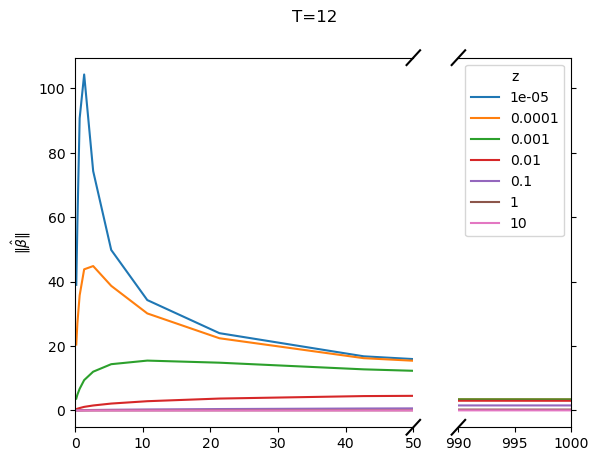

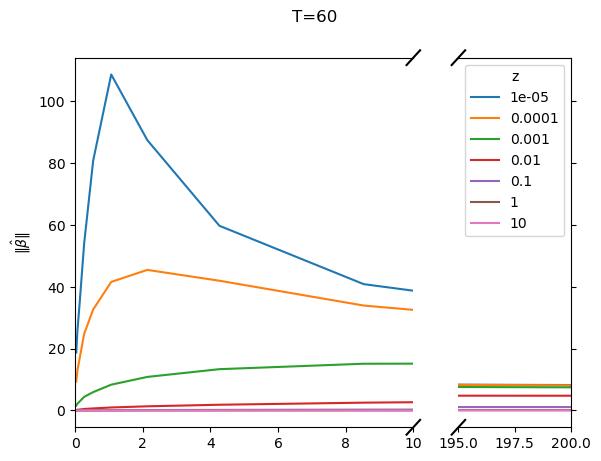

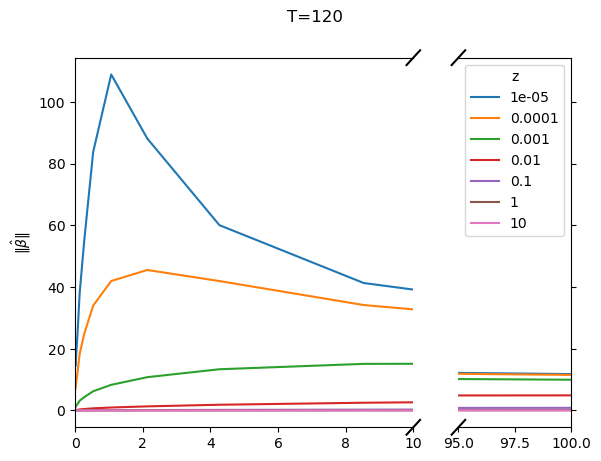

In [28]:
for T in T_list:
    plot_broken_x(beta_norm, T, z_list, 
                  y_label=r'$\| \hat {\beta}\|$', 
                  save_path=f"../reports/figures/beta_norm_T{T}_seed{seed}.png",
                  ytype=None)

## 3.3 Out-of-sample $R^2$ 



[VoC] Our empirical R2 calculation is one minus the ratio of out-of-sample forecast error variance to out-of-sample realized return variance. 

$$ R^2 = 1 - \frac{Var[R-\hat{R}]}{Var[R]}$$

In [29]:
realized_R = data.R.iloc[12:]
forecast_errors = return_forecasts_df.subtract(realized_R, axis=0)
R_sq = 1 - forecast_errors.var() / realized_R.var()
R_sq_temp = (R_sq
             .to_frame()
             .unstack()
             .droplevel(0, axis=1)
             .reset_index()
             )
R_sq_temp['c'] = R_sq_temp['P']/R_sq_temp['T']
R_sq_temp.head()


z,T,P,0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,c
0,12,2,-0.169784,-0.050306,-0.003250,-0.000701,-0.000553,-0.000539,-0.000538,0.166667
1,12,4,-0.364887,-0.089150,-0.005562,-0.000846,-0.000566,-0.000541,-0.000538,0.333333
2,12,8,-0.789231,-0.153826,-0.011241,-0.001290,-0.000609,-0.000545,-0.000539,0.666667
3,12,16,-0.944389,-0.167940,-0.005749,-0.000187,-0.000489,-0.000533,-0.000537,1.333333
4,12,32,-0.493078,-0.177996,-0.010789,-0.000146,-0.000471,-0.000531,-0.000537,2.666667


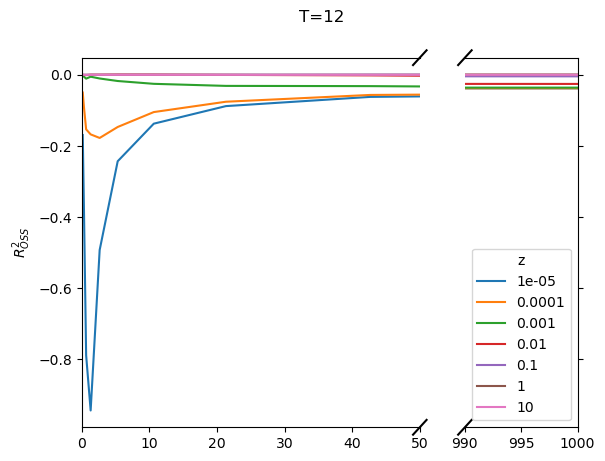

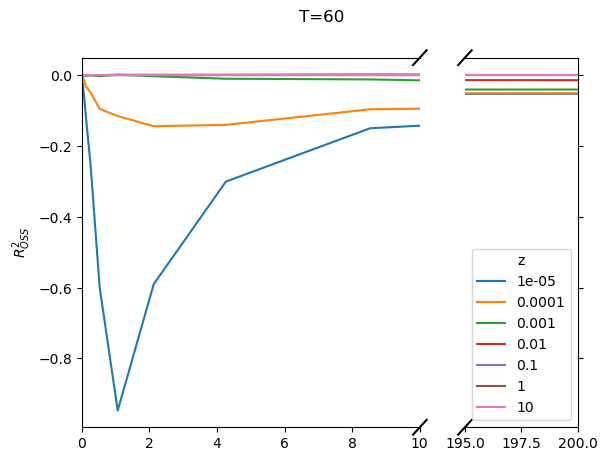

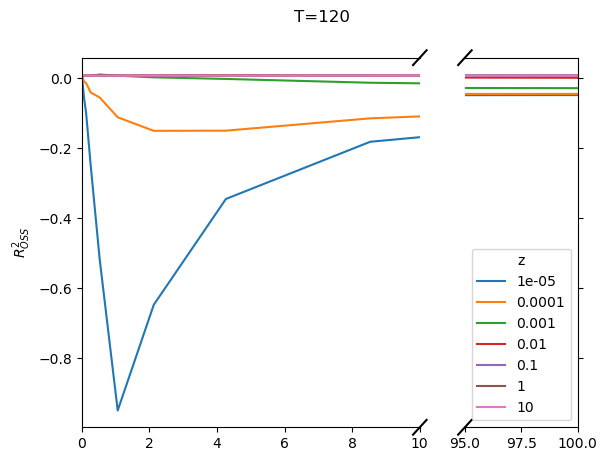

In [30]:
for T in T_list:
    plot_broken_x(R_sq_temp, T, z_list,
                  r'$R_{OSS}^2$',
                  f"../reports/figures/R2_T{T}_seed{seed}.png")

## 3.4 Out-of-sample average return of the timing strategy


In [31]:
strategy_returns = strategy_returns_df.mean().unstack().reset_index()
strategy_returns['c'] = strategy_returns['P']/strategy_returns['T']
strategy_returns.head()

z,T,P,0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,c
0,12,2,-0.005997,-0.002266,-0.000287,-0.000029,-0.000003,-2.909835e-07,-2.909855e-08,0.166667
1,12,4,-0.010857,-0.005538,-0.000868,-0.000090,-0.000009,-9.038823e-07,-9.039083e-08,0.333333
2,12,8,-0.010956,-0.013573,-0.002567,-0.000276,-0.000028,-2.784686e-06,-2.784869e-07,0.666667
3,12,16,0.040999,0.011813,0.003186,0.000438,0.000046,4.583832e-06,4.585773e-07,1.333333
4,12,32,0.020714,0.010958,0.003933,0.000638,0.000069,6.938214e-06,6.943834e-07,2.666667


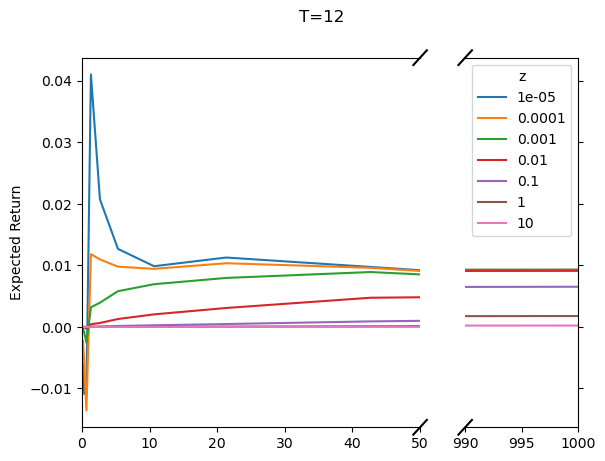

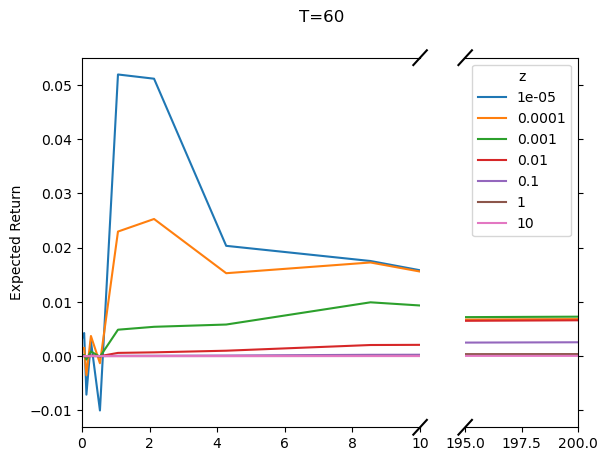

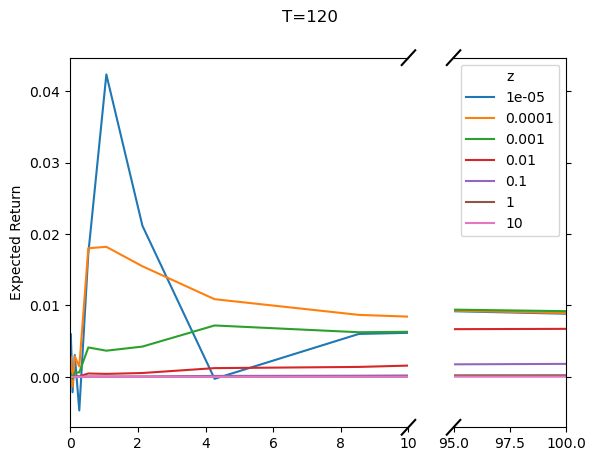

In [32]:
for T in T_list:
    plot_broken_x(strategy_returns, T, z_list,
                  "Expected Return",
                  f"../reports/figures/ER_T{T}_seed{seed}.png",
                  ytype=None)

## 3.5 Volatility of the timing strategy

In [33]:
strategy_vola = strategy_returns_df.std().unstack().reset_index()
strategy_vola['c'] = strategy_vola['P']/strategy_vola['T']

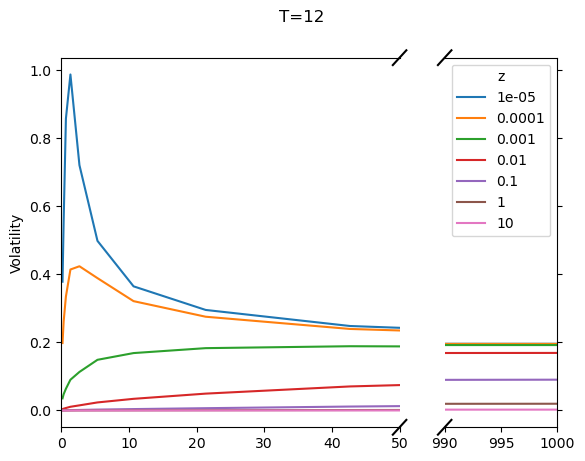

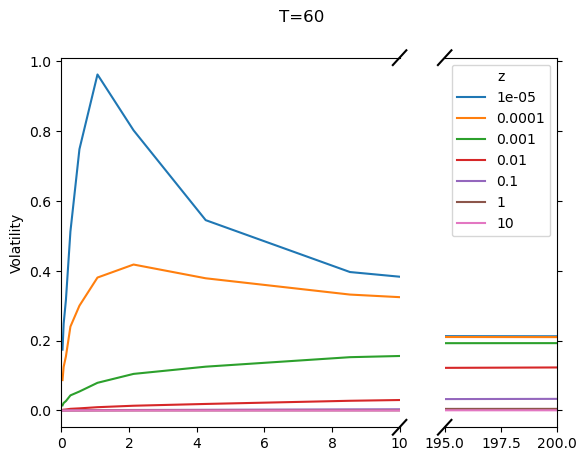

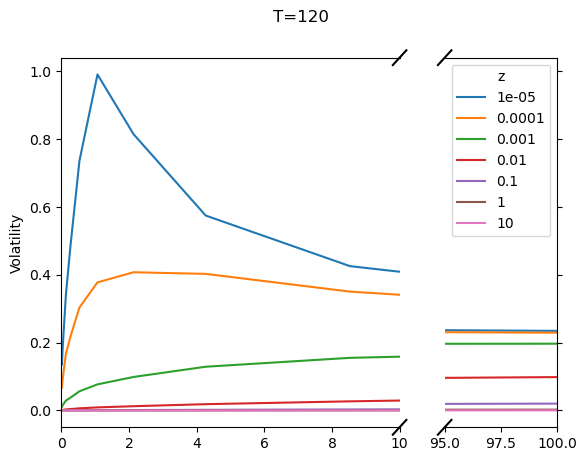

In [34]:
for T in T_list:
    plot_broken_x(strategy_vola, T, z_list,
                  "Volatility",
                  f"../reports/figures/vola_T{T}_seed{seed}.png",
                  ytype=None)

## 3.6 Sharpe ratio of the timing strategy

Our empirical Sharpe ratio calculation uses the centered standard deviation in the denominator.

# 4. Generate VoC curves by averaging over many runs

In [56]:
# for seed in range(151, 218) load results, calculate metrics and average dataframes over different seeds
from_seed = 160
to_seed = 217

# z_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000] # 1-150
z_list = [0.00001, 0.00003, 0.0001, 0.001, 0.01, 0.1, 1] # 160-217
# z_list=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

run_params_unpacking = (T_list, P_list, z_list) # !!!! IMPORTANT: using run_params instead of z_list causes a bug!!!
run_params_unpacking

first_pass = True

for seed in range(from_seed, to_seed+1):

    # load results
    b = np.load(f"../data/interim/simulation_outputs/beta_norm_sq/{seed:04}beta_norm_sq.npy")
    r = np.load(f"../data/interim/simulation_outputs/return_forecasts/{seed:04}return_forecasts.npy")
    sr = np.load(f"../data/interim/simulation_outputs/strategy_returns/{seed:04}strategy_returns.npy")

    # unpack results
    beta_norm_sq_df, return_forecasts_df, strategy_returns_df = unpack_results((b, r, sr), run_params_unpacking, dates)

    # calculate metrics
    # beta
    mean_beta_norm_sq = beta_norm_sq_df.mean().unstack()
    beta_norm = np.sqrt(mean_beta_norm_sq) # in VoC paper they plotted square root of norm of beta
    beta_norm = beta_norm.reset_index()
    beta_norm['c'] = beta_norm['P']/beta_norm['T']

    # R2
    realized_R = data.R.iloc[12:]
    forecast_errors = return_forecasts_df.subtract(realized_R, axis=0)
    R_sq = 1 - forecast_errors.var() / realized_R.var()
    R_sq_temp = (R_sq
                .to_frame()
                .unstack()
                .droplevel(0, axis=1)
                .reset_index()
                )
    R_sq_temp['c'] = R_sq_temp['P']/R_sq_temp['T']
    R_sq_temp.head()

    # expected returns
    strategy_returns = strategy_returns_df.mean().unstack().reset_index()
    strategy_returns['c'] = strategy_returns['P']/strategy_returns['T']
    strategy_returns.head()

    # volatility
    strategy_vola = strategy_returns_df.std().unstack().reset_index()
    strategy_vola['c'] = strategy_vola['P']/strategy_vola['T']

    if first_pass:
        beta_norm_avg = beta_norm
        R_sq_avg = R_sq_temp
        strategy_returns_avg = strategy_returns
        strategy_vola_avg = strategy_vola
    else:
        # average dataframes over different seeds
        # fill_value=0 makes addition use 0 for missing values. I did not see any NaNs in the dataframes
        beta_norm_avg = beta_norm_avg.add(beta_norm, fill_value=0) 
        R_sq_avg = R_sq_avg.add(R_sq_temp, fill_value=0)
        strategy_returns_avg = strategy_returns_avg.add(strategy_returns, fill_value=0)
        strategy_vola_avg = strategy_vola_avg.add(strategy_vola, fill_value=0)

beta_norm_avg.loc[:,z_list] = beta_norm_avg.loc[:,z_list] / (to_seed - from_seed)
R_sq_avg.loc[:,z_list] = R_sq_avg.loc[:,z_list] / (to_seed - from_seed)
strategy_returns_avg.loc[:,z_list] = strategy_returns_avg.loc[:,z_list] / (to_seed - from_seed)
strategy_vola_avg.loc[:,z_list] = strategy_vola_avg.loc[:,z_list] / (to_seed - from_seed)


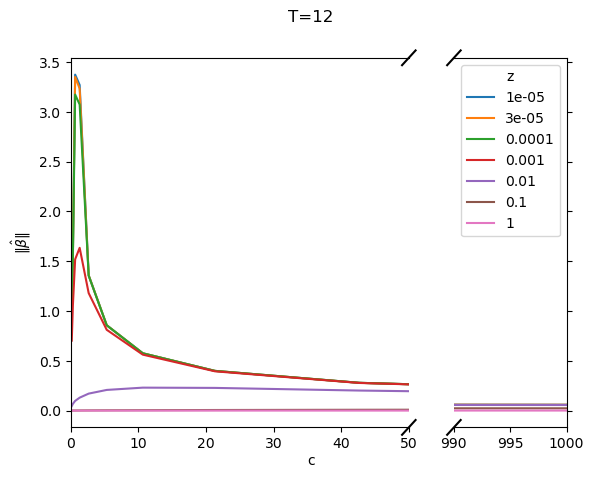

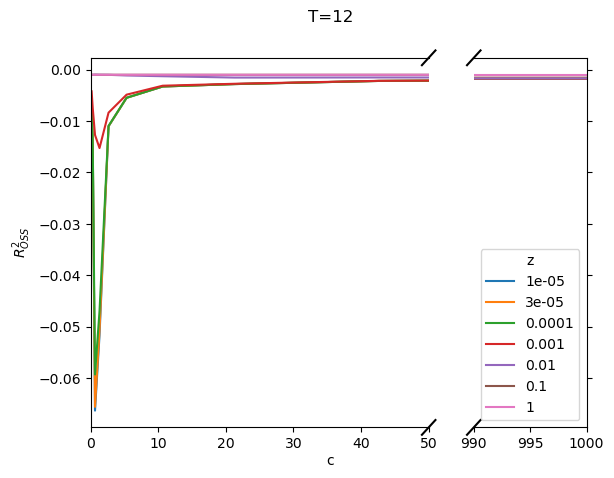

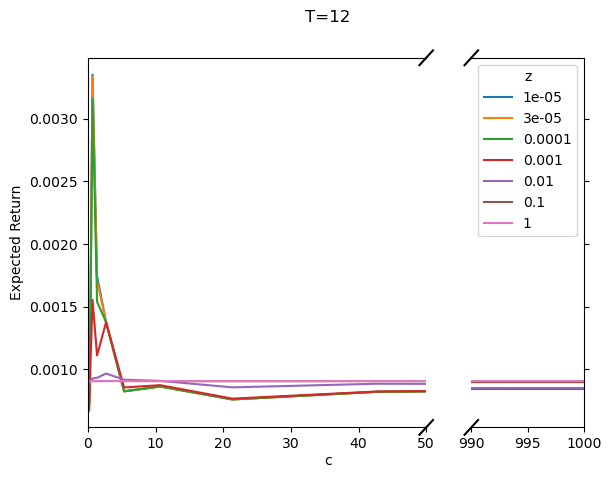

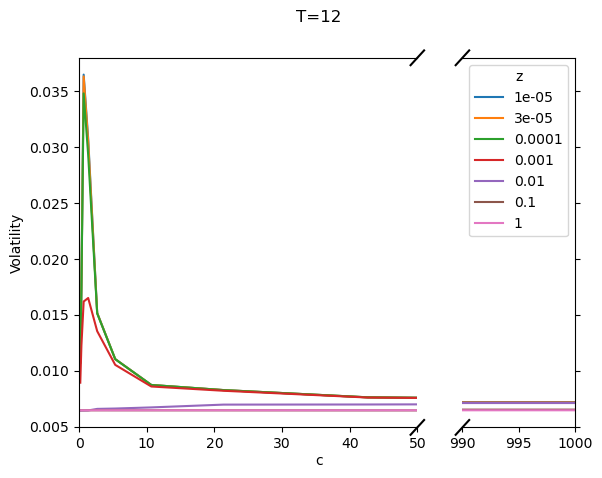

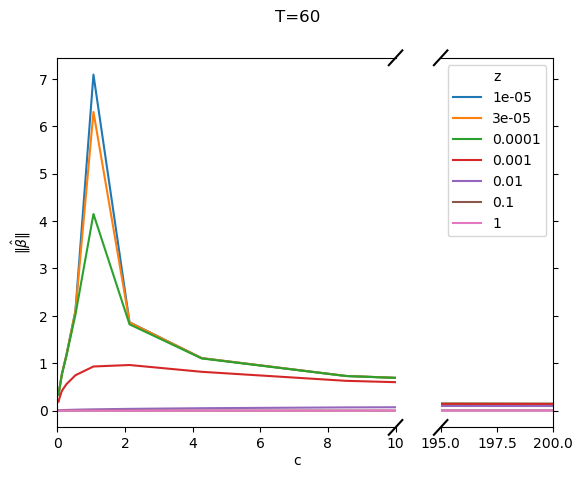

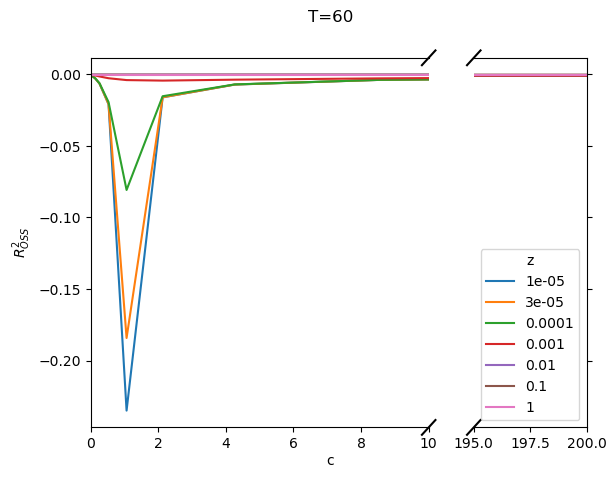

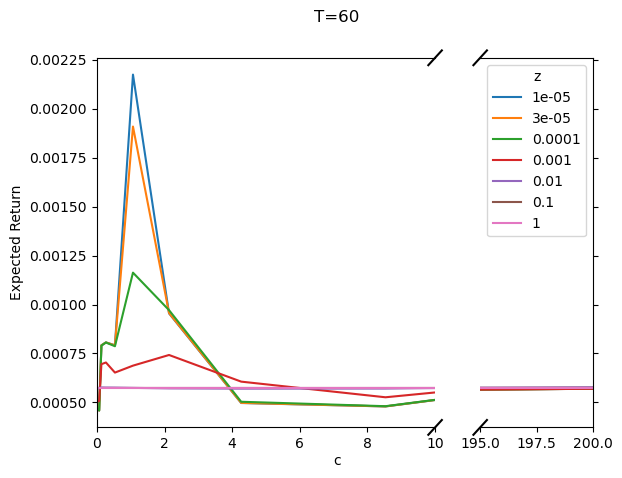

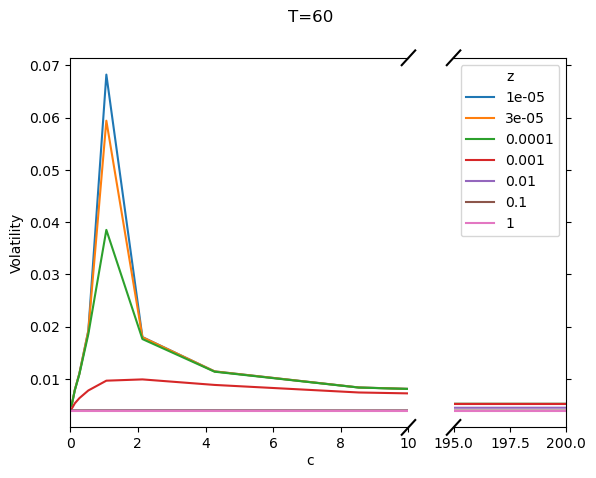

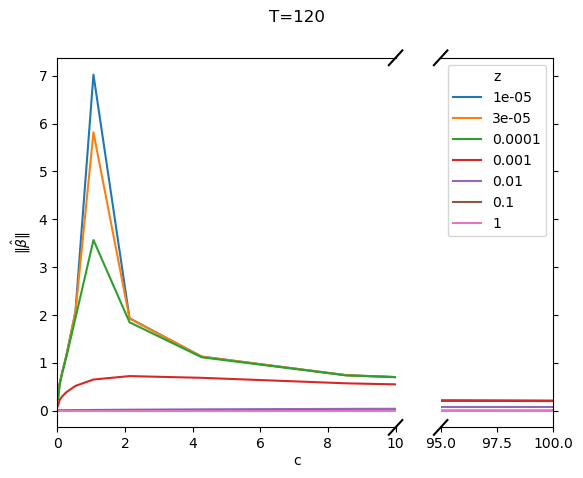

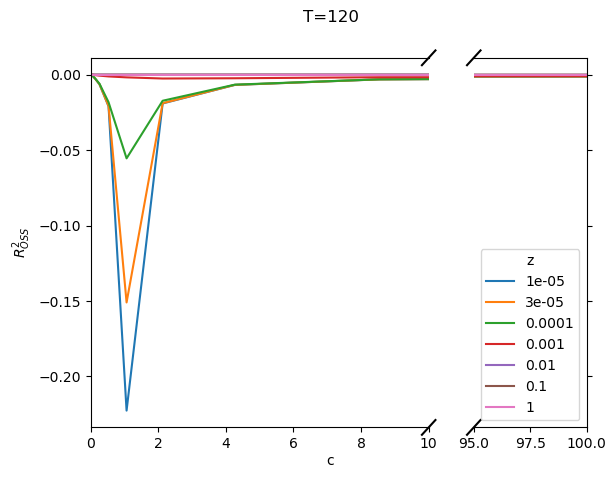

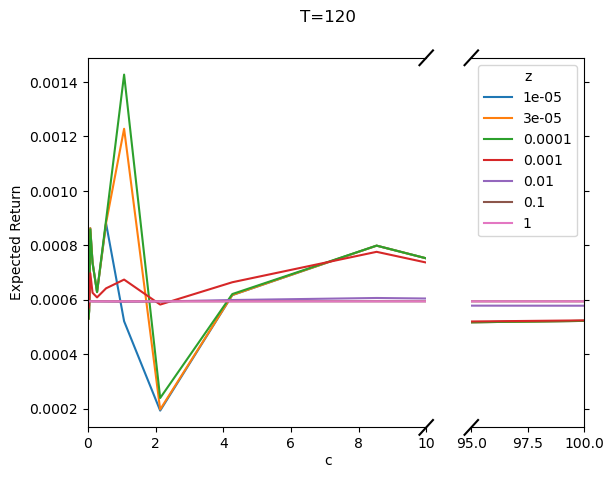

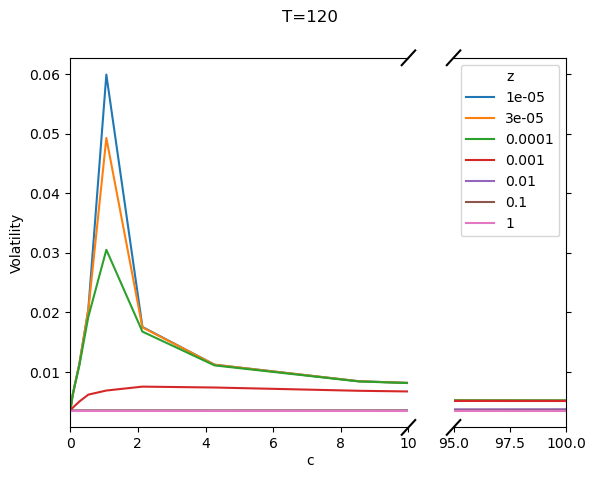

In [62]:
# plot averaged dataframes
for T in T_list:
    plot_broken_x(beta_norm_avg, T, z_list, 
                  y_label=r'$\| \hat {\beta}\|$', 
                  save_path=f"../reports/figures/beta_norm_T{T}_seed{from_seed}_{to_seed}.png")
    plot_broken_x(R_sq_avg, T, z_list,
                    r'$R_{OSS}^2$',
                    f"../reports/figures/R2_T{T}_seed{from_seed}_{to_seed}.png")
    plot_broken_x(strategy_returns_avg, T, z_list,
                    "Expected Return",
                    f"../reports/figures/ER_T{T}_seed{from_seed}_{to_seed}.png")
    plot_broken_x(strategy_vola_avg, T, z_list,
                    "Volatility",
                    f"../reports/figures/vola_T{T}_seed{from_seed}_{to_seed}.png")
    
    